<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Task-research" data-toc-modified-id="Task-research-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Task research</a></span></li><li><span><a href="#Fighting-the-imbalance" data-toc-modified-id="Fighting-the-imbalance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fighting the imbalance</a></span><ul class="toc-item"><li><span><a href="#Balanced" data-toc-modified-id="Balanced-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Balanced</a></span></li><li><span><a href="#Upsampled" data-toc-modified-id="Upsampled-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Upsampled</a></span></li><li><span><a href="#Downsampled" data-toc-modified-id="Downsampled-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Downsampled</a></span></li></ul></li><li><span><a href="#Testing-the-model" data-toc-modified-id="Testing-the-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing the model</a></span></li></ul></div>

# Customer outflow

Customers began to leave Beta Bank. Every month. A little, but noticeable. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. You are presented with historical data on the behavior of customers and the termination of contracts with the bank. 

Build a model with an extremely large value of *F1*-measures. To pass the project successfully, you need to bring the metric to 0.59. Check the *F1* measure on the test sample yourself.

Additionally measure *AUC-ROC*, compare its value with *F1*-measure.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data preparation

Import the libraries needed for the study and prepare the data:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('datasets/Churn.csv')
data = data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
data['Tenure'] = data.fillna(data['Tenure'].median())

print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  object 
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 859.5+ KB
None
        CreditScore           Age        Balance  NumOfProducts    HasCrCard  \
count  10000.000000  10000.000000   10000.000000   10000.000000  10000.00000   
mean     650.528800     38.921800   76485.889288       1.530200  

In [3]:
target = data['Exited']
features = data.drop(['Exited'], axis=1)

features_train, features_test, target_train, target_test = (
    train_test_split(features,
                     target,
                     test_size=.2,
                     random_state=12345)
)

features_train, features_valid, target_train, target_valid = (
    train_test_split(features_train,
                    target_train,
                     test_size=.25,
                    random_state=12345)
)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(6000, 10)
(2000, 10)
(2000, 10)
(6000,)
(2000,)
(2000,)


Let's scale the data.

In [4]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = (
        shuffle(features_upsampled, target_upsampled, random_state=12345)
    )
    
    return features_upsampled, target_upsampled

def downsample(features, target, frac):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros] + [features_ones.sample(frac=frac, random_state=12345)])
    target_downsampled = pd.concat([target_zeros] + [target_ones.sample(frac=frac, random_state=12345)])
    
    features_downsampled, target_downsampled = (
        shuffle(features_downsampled, target_downsampled, random_state=12345)
    )
    
    return features_downsampled, target_downsampled


In [5]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)
print(features_train_upsampled.shape)
print(target_train_upsampled.shape)

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, .2)
print(features_train_downsampled.shape)
print(target_train_downsampled.shape)

(9657, 10)
(9657,)
(5025, 10)
(5025,)


Encode the dataset using the One Hot Encoding method and perform upsampling.

In [6]:
encoder = OneHotEncoder(handle_unknown='ignore')

features_train_upsampled = encoder.fit_transform(features_train_upsampled, target_train_upsampled)
features_train_ohe = encoder.transform(features_train)
features_valid_ohe = encoder.transform(features_valid)
features_test_ohe = encoder.transform(features_test)


print(features_train_upsampled.shape)
print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(features_test_ohe.shape)

(9657, 10819)
(6000, 10819)
(2000, 10819)
(2000, 10819)


Conduct downsampling of the features.

In [7]:
features_train_downsampled = encoder.fit_transform(features_train_downsampled, target_train_downsampled)
features_train_down = encoder.transform(features_train)
features_valid_down = encoder.transform(features_valid)
features_test_down = encoder.transform(features_test)

print(features_train_downsampled.shape)
print(features_train_down.shape)
print(features_valid_down.shape)
print(features_test_down.shape)

(5025, 9069)
(6000, 9069)
(2000, 9069)
(2000, 9069)


Features such as Last Name, Line Number and Unique Identification Number have been removed from the dataset, as they are uninformative and do not give any idea about the behavior and actions of customers.

## Task research

Standardize the data using the Standard Scaler method

In [8]:
scaler = StandardScaler(with_mean=False)

features_train_upsampled = scaler.fit_transform(features_train_upsampled)
features_train_ohe = scaler.transform(features_train_ohe)
features_valid_ohe = scaler.transform(features_valid_ohe)
features_test_ohe = scaler.transform(features_test_ohe)


print(features_train_upsampled.shape)
print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(features_test_ohe.shape)

(9657, 10819)
(6000, 10819)
(2000, 10819)
(2000, 10819)


In [9]:
features_train_downsampled = scaler.fit_transform(features_train_downsampled)
features_train_down = scaler.transform(features_train_down)
features_valid_down = scaler.transform(features_valid_down)
features_test_down = scaler.transform(features_test_down)

print(features_train_downsampled.shape)
print(features_train_down.shape)
print(features_valid_down.shape)
print(features_test_down.shape)

(5025, 9069)
(6000, 9069)
(2000, 9069)
(2000, 9069)


Train the Random Forest model.

In [10]:
best_model_f1 = 0
depth = 0
n_estimatores = 0

for n_est in range(10, 101, 10):
    for depth in range(1, 51, 1):
        model = RandomForestClassifier(
            random_state=12345, 
            max_depth=depth, 
            n_estimators=n_est)
        model.fit(features_train_ohe, target_train)
        predictions_valid = model.predict(features_valid_ohe)
        f1_valid = f1_score(target_valid, predictions_valid)
        if f1_valid > best_model_f1:
            best_model_f1 = f1_valid
            depth = depth
            n_estimators = n_est
            
print(f'Best model: F1 = {best_model_f1}, depth = {depth}, n_estimators = {n_estimators}')

Лучшая модель: F1 = 0.24724061810154527, depth = 50, n_estimators = 20


Train the Decision Tree model.

In [11]:
best_model_f1 = 0
depth = 0
for depth in range(1, 51, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train_ohe, target_train)
    predicted_valid = model.predict(features_valid_ohe)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_model_f1:
        best_model_f1 = f1
        depth = depth
        
print(f'Best model: F1 = {best_model_f1}, depth = {depth}')

Лучшая модель: F1 = 0.5067873303167421, depth = 50


Train the Logistic Regression model.

In [12]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_ohe, target_train)
predicted_valid = model.predict(features_valid_ohe)
f1 = f1_score(target_valid, predicted_valid)
print(f'Best model: F1 = {f1}')


Лучшая модель: F1 = 0.5085130533484676


The best indicator for the F1 metric without taking into account the data imbalance was shown by the Logistic Regression model, the worst was Random Forest.

## Fighting the imbalance

### Balanced

Train a Random Forest model with class_weight='balanced' attributes.

In [13]:
best_model_f1 = 0
depth = 0
n_estimatores = 0

for n_est in range(10, 101, 10):
    for depth in range(1, 51, 1):
        model = RandomForestClassifier(
            class_weight='balanced',
            random_state=12345, 
            max_depth=depth, 
            n_estimators=n_est)
        model.fit(features_train_ohe, target_train)
        predictions_valid = model.predict(features_valid_ohe)
        f1_valid = f1_score(target_valid, predictions_valid)
        if f1_valid > best_model_f1:
            best_model_f1 = f1_valid
            depth = depth
            n_estimators = n_est
            
print(f'Best model: F1 = {best_model_f1}, depth = {depth}, n_estimators = {n_estimators}')

Лучшая модель: F1 = 0.5765306122448979, depth = 50, n_estimators = 70


Train the Decision Tree model with class_weight='balanced' attributes.

In [14]:
best_model_f1 = 0
depth = 0
for depth in range(1, 51, 1):
    model = DecisionTreeClassifier(class_weight='balanced', random_state=12345, max_depth=depth)
    model.fit(features_train_ohe, target_train)
    predicted_valid = model.predict(features_valid_ohe)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_model_f1:
        best_model_f1 = f1
        depth = depth
        
print(f'Best model: F1 = {best_model_f1}, depth = {depth}')

Лучшая модель: F1 = 0.5296251511487304, depth = 50


Train a Linear Regression model with class_weight='balanced' attributes.

In [15]:
model = LogisticRegression(class_weight='balanced', random_state=12345, solver='liblinear')
model.fit(features_train_ohe, target_train)
predicted_valid = model.predict(features_valid_ohe)
f1 = f1_score(target_valid, predicted_valid)
print(f'Лучшая модель: F1 = {f1}')


Лучшая модель: F1 = 0.4995159728944821


The best indicator for the F1 metric was shown by the Random Forest model, the worst - Linear Regression.

### Upsampled

Train a Random Forest model with upsampled features.

In [16]:
best_model_f1 = 0
depth = 0
n_estimatores = 0

for n_est in range(10, 101, 10):
    for depth in range(1, 51, 1):
        model = RandomForestClassifier(
            class_weight='balanced',
            random_state=12345, 
            max_depth=depth, 
            n_estimators=n_est)
        model.fit(features_train_upsampled, target_train_upsampled)
        predictions_valid = model.predict(features_valid_ohe)
        f1_valid = f1_score(target_valid, predictions_valid)
        if f1_valid > best_model_f1:
            best_model_f1 = f1_valid
            depth = depth
            n_estimators = n_est
            
print(f'Best model: F1 = {best_model_f1}, depth = {depth}, n_estimators = {n_estimators}')

Лучшая модель: F1 = 0.5805714285714285, depth = 50, n_estimators = 100


Train a Decision Tree model with upsampled features.

In [17]:
best_model_f1 = 0
depth = 0
for depth in range(1, 51, 1):
    model = DecisionTreeClassifier(class_weight='balanced', random_state=12345, max_depth=depth)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid_ohe)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_model_f1:
        best_model_f1 = f1
        depth = depth
        
print(f'Best model: F1 = {best_model_f1}, depth = {depth}')

Лучшая модель: F1 = 0.5289672544080605, depth = 50


Train a Linear Regression model with upsampled features.

In [18]:
model = LogisticRegression(class_weight='balanced', random_state=12345, solver='liblinear')
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid_ohe)
f1 = f1_score(target_valid, predicted_valid)
print(f'Best model: F1 = {f1}')


Лучшая модель: F1 = 0.5004849660523764


The best indicator for the F1 metric was again shown by the Random Forest model, the worst - Linear Regression.

### Downsampled

Train a Random Forest model with downsampled features.

In [19]:
best_model_f1 = 0
depth = 0
n_estimatores = 0

for n_est in range(10, 101, 10):
    for depth in range(1, 51, 1):
        model = RandomForestClassifier(
            class_weight='balanced',
            random_state=12345, 
            max_depth=depth, 
            n_estimators=n_est)
        model.fit(features_train_downsampled, target_train_downsampled)
        predictions_valid = model.predict(features_valid_down)
        f1_valid = f1_score(target_valid, predictions_valid)
        if f1_valid > best_model_f1:
            best_model_f1 = f1_valid
            depth = depth
            n_estimators = n_est
            
print(f'Best model: F1 = {best_model_f1}, depth = {depth}, n_estimators = {n_estimators}')

Лучшая модель: F1 = 0.5298165137614679, depth = 50, n_estimators = 100


Train a Decision Tree model with downsampled features.

In [20]:
best_model_f1 = 0
depth = 0
for depth in range(1, 51, 1):
    model = DecisionTreeClassifier(class_weight='balanced', random_state=12345, max_depth=depth)
    model.fit(features_train_downsampled, target_train_downsampled)
    predicted_valid = model.predict(features_valid_down)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_model_f1:
        best_model_f1 = f1
        depth = depth
        
print(f'Best model: F1 = {best_model_f1}, depth = {depth}')

Лучшая модель: F1 = 0.5185185185185185, depth = 50


Train a Linear Regression model with downsampled features.

In [21]:
model = LogisticRegression(class_weight='balanced', random_state=12345, solver='liblinear')
model.fit(features_train_downsampled, target_train_downsampled)
predicted_valid = model.predict(features_valid_down)
f1 = f1_score(target_valid, predicted_valid)
print(f'Лучшая модель: F1 = {f1}')


Лучшая модель: F1 = 0.05405405405405405


The best indicator for the F1 metric was shown by the Random Forest model, the worst - Logistic Regression.

## Testing the model

Testing the Random Forest model on balanced data.

In [22]:
best_model_RF = None
best_model_f1 = 0
depth = 0
n_estimatores = 0

for n_est in range(10, 101, 10):
    for depth in range(1, 51, 1):
        model = RandomForestClassifier(
            class_weight='balanced_subsample',
            random_state=12345, 
            max_depth=depth, 
            n_estimators=n_est)
        model.fit(features_train_upsampled, target_train_upsampled)
        predictions_test = model.predict(features_test_ohe)
        f1_valid = f1_score(target_test, predictions_test)
        if f1_valid > best_model_f1:
            best_model_RF = model
            best_model_f1 = f1_valid
            depth = depth
            n_estimators = n_est
            
print(f'Best model: F1 = {best_model_f1}, depth = {depth}, n_estimators = {n_estimators}')

Лучшая модель: F1 = 0.5970149253731344, depth = 50, n_estimators = 30


On the test sample, the Random Forest model shows the value of the F1 metric equal to ~0.60

Let's measure the AUC-ROC metric and compare its value with the F1 metric.

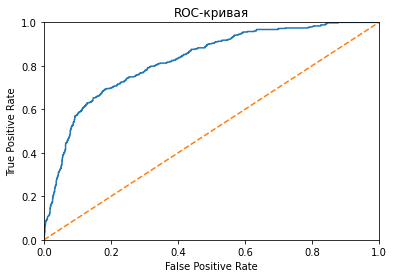

Значение метрики AUC-ROC: 0.825523954436026


In [23]:
probabilities_test = best_model_RF.predict_proba(features_test_ohe)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-curve')
plt.show()

print('The value of the AUC-ROC metric:', roc_auc_score(target_test, probabilities_one_test))

As can be seen from the graph of the ROC curve and the value of the AUC_ROC metric ~0.83, the model turned out to be of high quality and very different from random, while the F1 measure shows high density and accuracy of the model.

During the study, several types of models were trained, these are Random Forest, Decision Tree and Logistic Regression.

The indicators of the F1 metric were also studied for various samples, balanced, upsampled and downsampled, as a result of which the most optimal Random Forest model was found with hyperparameters depth=50, n_estimators=50, the F1 metric of which is ~0.6

The following steps were taken:
- The original dataset has been studied.
- Preprocessed signs.
- The samples were divided into training, validation and test.
- Data encoding was performed using the One Hot Encoding method.
- Data scaling was performed on upsampled and downsampled.
- Three models have been trained on unbalanced data.
- Models are trained on balanced, upsampled, downsampled samples.
- Testing the best Random Forest model.
- Calculation of the AUC-ROC metric and its comparison with the F1 metric.